<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

import numpy as np

from keras.layers import Input, Layer, Dense
from keras.models import Model
from keras.losses import mean_squared_error
from keras.initializers import Constant
from keras.optimizers import SGD
from keras.callbacks import Callback
import keras.backend as K

from matplotlib import pyplot as plt

Using TensorFlow backend.


### Adding homoscedastic error to loss

In [0]:
x = np.random.randn(100000, 5)
y = x.max(axis=1) + 0.01*np.random.randn(100000)

In [0]:
class ConstSqLayer(Layer):
  def __init__(self, **kwargs):
    super(ConstSqLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.sig = self.add_weight(name='sigma', shape=(1,), initializer=Constant(value=1), trainable=True)
    super(ConstSqLayer, self).build(input_shape)

  def call(self, x):
    const = K.ones_like(x)
    sig_arr = self.sig*const
    return K.square(sig_arr)

  def compute_output_shape(self, input_shape):
    return input_shape

In [0]:
def noise_loss_factory(sig2, original_loss):
  def loss(y_true, y_pred):
    return original_loss(y_true, y_pred)/sig2 + K.log(sig2)
  return loss

In [0]:
K.clear_session()

inp_layer = Input(shape=(5,))
h = Dense(5, activation='relu')(inp_layer)
out = Dense(1, name='main_output')(h)

sig2 = ConstSqLayer(name='sig2_output')(out)

mdl = Model(inputs=[inp_layer], outputs=[out,sig2])

In [9]:
mdl.compile('sgd', loss={'main_output':noise_loss_factory(sig2, mean_squared_error)})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Output "sig2_output" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "sig2_output" during training.
  """Entry point for launching an IPython kernel.


In [10]:
mdl.fit(x=x, y=y, batch_size=100, epochs=10)




Epoch 1/10





100000/100000 [==============================] - 2s 18us/step - loss: -0.8468 - main_output_loss: -0.8468
Epoch 2/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.2290 - main_output_loss: -1.2290
Epoch 3/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3211 - main_output_loss: -1.3211
Epoch 4/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3431 - main_output_loss: -1.3431
Epoch 5/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3467 - main_output_loss: -1.3467
Epoch 6/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3450 - main_output_loss: -1.3450
Epoch 7/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3417 - main_output_loss: -1.3417
Epoch 8/10
100000/100000 [==============================] - 1s 11us/step - loss: -1.3450 - main_output_loss: -1.3450
Epoch 9/10
100000/100000 [==============================

In [11]:
a = np.random.randn(1,5)
a, mdl.predict(a)

(array([[ 1.56976762, -0.69525888, -0.19254441, -0.96528685,  0.23699563]]),
 [array([[1.2647722]], dtype=float32), array([[0.09538909]], dtype=float32)])

In [12]:
K.clear_session()

inp_layer = Input(shape=(5,))
h = Dense(5, activation='relu')(inp_layer)
out = Dense(1, name='main_output')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss='mse')
mdl.fit(x=x, y=y, batch_size=100, epochs=10)

Epoch 1/10
100000/100000 [==============================] - 1s 11us/step - loss: 0.2534
Epoch 2/10
100000/100000 [==============================] - 1s 10us/step - loss: 0.1266
Epoch 3/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0932
Epoch 4/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0774
Epoch 5/10
100000/100000 [==============================] - 1s 10us/step - loss: 0.0748
Epoch 6/10
100000/100000 [==============================] - 1s 10us/step - loss: 0.0735
Epoch 7/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0724
Epoch 8/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0716
Epoch 9/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0710
Epoch 10/10
100000/100000 [==============================] - 1s 9us/step - loss: 0.0704


In [13]:
a = np.random.randn(1,5)
a, mdl.predict(a)

(array([[-0.5729907 ,  1.23293485, -1.08772103, -0.38531663, -0.95405958]]),
 array([[0.95663047]], dtype=float32))

### Mixed entropy loss

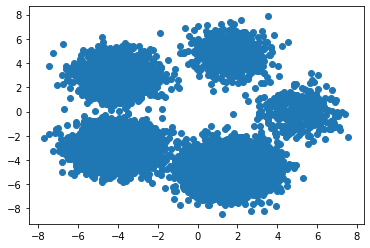

In [4]:
def mixed_entropy_loss(y_true, y_pred):
  eps=1e-10
  mean = K.mean(y_pred, axis=0)

  nentropy_mean = K.mean(K.sum(y_pred*K.log(y_pred+eps), axis=1))
  mean_nentropy = K.sum(mean*K.log(mean+eps))

  return mean_nentropy - nentropy_mean

def get_data(n, clusters=list('abc'), dist=5, cluster_weight=None):
  cluster_shift_dict = {c:np.array([np.cos(2*k*np.pi/len(clusters)), np.sin(2*k*np.pi/len(clusters))]) for k, c in enumerate(clusters)}
  if cluster_weight is None:
    cluster_id = np.random.choice(clusters, n)
  else:
    cluster_id = np.random.choice(clusters, n, p=np.array(cluster_weight)/sum(cluster_weight))
  cluster_shift = np.array([cluster_shift_dict[c] for c in cluster_id])
  
  x = np.random.randn(n,2) + dist*cluster_shift

  return x

x = get_data(10000, clusters=list('abcde'), cluster_weight=[1,2,4,8,16])
plt.scatter(x[:,0], x[:,1])
plt.show()

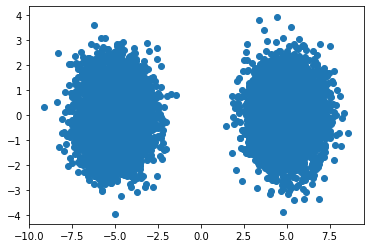

In [36]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

plt.scatter(x[:,0], x[:,1])
plt.show()

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out = Dense(2, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [39]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 0s 45us/step - loss: -0.5927
Epoch 2/10
10000/10000 [==============================] - 0s 28us/step - loss: -0.6699
Epoch 3/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.6751
Epoch 4/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.6741
Epoch 5/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.6740
Epoch 6/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.6764
Epoch 7/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.6760
Epoch 8/10
10000/10000 [==============================] - 0s 28us/step - loss: -0.6741
Epoch 9/10
10000/10000 [==============================] - 0s 32us/step - loss: -0.6732
Epoch 10/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.6749


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [41]:
for k in range(10):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f}'.format(sgn,out_test[k,0]))

+ --> 0.00001
- --> 1.00000
- --> 1.00000
+ --> 0.00000
- --> 1.00000
+ --> 0.00024
- --> 0.99999
+ --> 0.00001
- --> 0.99987
- --> 1.00000


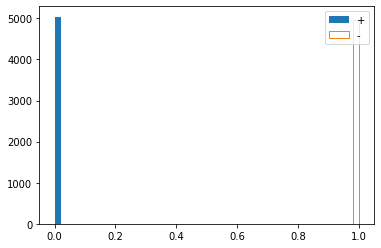

In [43]:
plusses = x_test[:,0]>0

fig, ax = plt.subplots()

ax.hist(out_test[plusses,0], bins=np.linspace(0,1,50), label='+')
ax.hist(out_test[~plusses,0], bins=np.linspace(0,1,50), label='-', histtype='step')

plt.legend()
plt.show()

### Mixed entropy loss with imbalanced classes

#### 90/10

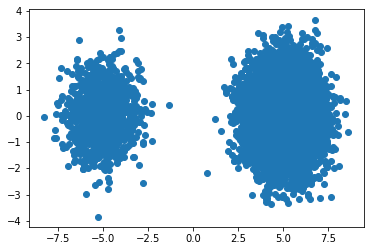

In [44]:
x = get_data(10000, clusters=list('ab'), cluster_weight=[90,10])
y = np.zeros((10000,2))

plt.scatter(x[:,0], x[:,1])
plt.show()

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out = Dense(2, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [46]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 1s 51us/step - loss: -0.1273
Epoch 2/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.2832
Epoch 3/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.3056
Epoch 4/10
10000/10000 [==============================] - 0s 32us/step - loss: -0.3059
Epoch 5/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.3083
Epoch 6/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.3062
Epoch 7/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.3116
Epoch 8/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.3100
Epoch 9/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.3112
Epoch 10/10
10000/10000 [==============================] - 0s 33us/step - loss: -0.3143


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [48]:
for k in range(10):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f}'.format(sgn,out_test[k,0]))

- --> 0.99939
- --> 0.99998
+ --> 0.00071
+ --> 0.00000
- --> 0.99997
+ --> 0.00001
+ --> 0.00001
- --> 0.99962
+ --> 0.00000
- --> 0.99991


Still accurate!

In [0]:
x_test = get_data(10000, clusters=list('ab'), cluster_weight=[90,10])
out_test = mdl.predict(x_test)

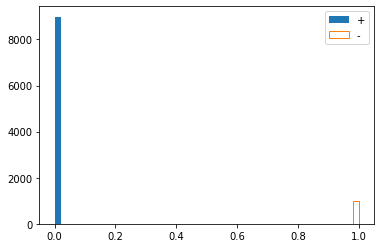

In [51]:
plusses = x_test[:,0]>0

fig, ax = plt.subplots()

ax.hist(out_test[plusses,0], bins=np.linspace(0,1,50), label='+')
ax.hist(out_test[~plusses,0], bins=np.linspace(0,1,50), label='-', histtype='step')

plt.legend()
plt.show()

#### 99/1

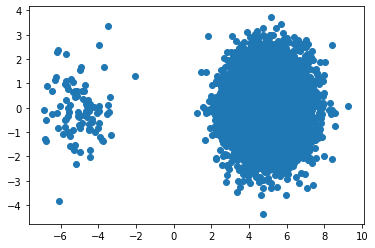

In [52]:
x = get_data(10000, clusters=list('ab'), cluster_weight=[99,1])
y = np.zeros((10000,2))

plt.scatter(x[:,0], x[:,1])
plt.show()

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out = Dense(2, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [54]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 1s 53us/step - loss: -0.0871
Epoch 2/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.1538
Epoch 3/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.2248
Epoch 4/10
10000/10000 [==============================] - 0s 32us/step - loss: -0.2956
Epoch 5/10
10000/10000 [==============================] - 0s 28us/step - loss: -0.3575
Epoch 6/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.4076
Epoch 7/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.4448
Epoch 8/10
10000/10000 [==============================] - 0s 32us/step - loss: -0.4723
Epoch 9/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.4937
Epoch 10/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.5130


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [56]:
for k in range(10):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f}'.format(sgn,out_test[k,0]))

+ --> 0.00175
- --> 0.10043
- --> 0.00000
+ --> 0.97365
- --> 0.03527
+ --> 0.97365
- --> 0.01687
- --> 0.01136
+ --> 0.00000
- --> 0.07835


fairly accurate on minority class - not accurate on majority

In [0]:
x_test = get_data(10000, clusters=list('ab'), cluster_weight=[99,1])
out_test = mdl.predict(x_test)

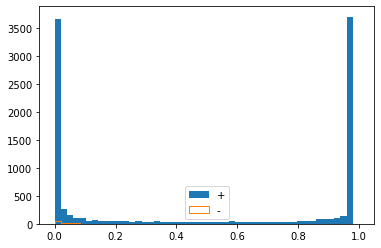

In [58]:
plusses = x_test[:,0]>0

fig, ax = plt.subplots()

ax.hist(out_test[plusses,0], bins=np.linspace(0,1,50), label='+')
ax.hist(out_test[~plusses,0], bins=np.linspace(0,1,50), label='-', histtype='step')

plt.legend()
plt.show()

### With extra classes in the model

#### Three classes

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(3, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [61]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 1s 59us/step - loss: -0.5962
Epoch 2/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.6698
Epoch 3/10
10000/10000 [==============================] - 0s 34us/step - loss: -0.6746
Epoch 4/10
10000/10000 [==============================] - 0s 33us/step - loss: -0.6746
Epoch 5/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.6788
Epoch 6/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.6772
Epoch 7/10
10000/10000 [==============================] - 0s 34us/step - loss: -0.6790
Epoch 8/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.6797
Epoch 9/10
10000/10000 [==============================] - 0s 36us/step - loss: -0.6805
Epoch 10/10
10000/10000 [==============================] - 0s 33us/step - loss: -0.6807


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [63]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f}'.format(sgn,out_test[k,0],out_test[k,1],out_test[k,2]))

          0       1       2
+ --> 0.00005 0.08762 0.91233
- --> 0.99998 0.00001 0.00001
- --> 1.00000 0.00000 0.00000
- --> 0.99999 0.00001 0.00001
+ --> 0.00250 0.22076 0.77674
+ --> 0.00029 0.11834 0.88137
- --> 0.99997 0.00001 0.00001
- --> 0.99950 0.00024 0.00026
- --> 0.99999 0.00000 0.00001
- --> 1.00000 0.00000 0.00000
+ --> 0.00031 0.13406 0.86563
+ --> 0.00110 0.11600 0.88290
+ --> 0.00027 0.12328 0.87644
+ --> 0.00002 0.06284 0.93714
+ --> 0.00010 0.05926 0.94064


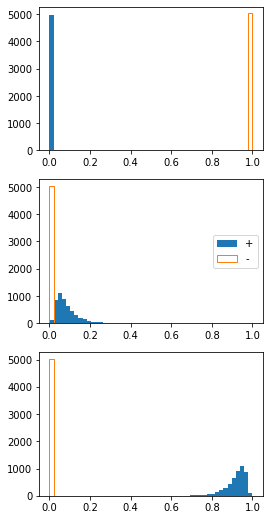

In [66]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(3)

for k, ax in enumerate(axs):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='center right')

fig.set_size_inches(4,9)
plt.show()

#### Four classes

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(4, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [69]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 1s 62us/step - loss: -0.5800
Epoch 2/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.6654
Epoch 3/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.6727
Epoch 4/10
10000/10000 [==============================] - 0s 32us/step - loss: -0.6762
Epoch 5/10
10000/10000 [==============================] - 0s 31us/step - loss: -0.6760
Epoch 6/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.6768
Epoch 7/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.6770
Epoch 8/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.6792
Epoch 9/10
10000/10000 [==============================] - 0s 30us/step - loss: -0.6807
Epoch 10/10
10000/10000 [==============================] - 0s 29us/step - loss: -0.6849


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [71]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2'+' '*7+'3')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f} {4:1.5f}'.format(sgn,out_test[k,0],out_test[k,1],out_test[k,2],out_test[k,3]))

          0       1       2       3
- --> 0.00000 0.00000 0.00002 0.99998
+ --> 0.02831 0.97142 0.00015 0.00012
- --> 0.00005 0.00000 0.00022 0.99974
+ --> 0.01130 0.98787 0.00048 0.00036
+ --> 0.02542 0.97424 0.00019 0.00015
+ --> 0.06063 0.93926 0.00006 0.00005
+ --> 0.02315 0.97658 0.00015 0.00012
- --> 0.00007 0.00000 0.00024 0.99968
+ --> 0.17327 0.82048 0.00328 0.00297
+ --> 0.00359 0.99640 0.00001 0.00001
+ --> 0.10702 0.89184 0.00061 0.00053
+ --> 0.07108 0.92862 0.00016 0.00014
+ --> 0.20575 0.79367 0.00030 0.00028
- --> 0.00002 0.00000 0.00009 0.99989
+ --> 0.01825 0.98158 0.00009 0.00007


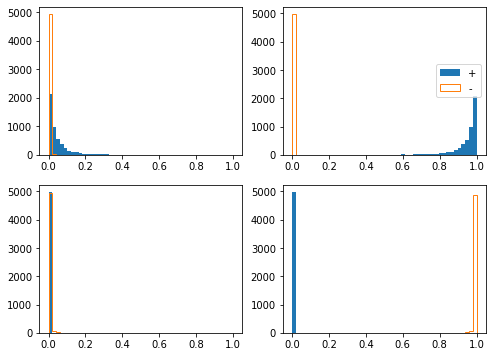

In [78]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(2,2)

for k, ax in enumerate(axs.flatten()):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='center right')

fig.set_size_inches(8,6)
plt.show()

#### Six classes

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(6, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [81]:
hist = mdl.fit(x,y, epochs=10, verbose=1)

Epoch 1/10
10000/10000 [==============================] - 1s 91us/step - loss: -0.6489
Epoch 2/10
10000/10000 [==============================] - 0s 37us/step - loss: -0.6822
Epoch 3/10
10000/10000 [==============================] - 0s 34us/step - loss: -0.6874
Epoch 4/10
10000/10000 [==============================] - 0s 37us/step - loss: -0.6896
Epoch 5/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.6898
Epoch 6/10
10000/10000 [==============================] - 0s 38us/step - loss: -0.6945
Epoch 7/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.6999
Epoch 8/10
10000/10000 [==============================] - 0s 35us/step - loss: -0.7083
Epoch 9/10
10000/10000 [==============================] - 0s 36us/step - loss: -0.7186
Epoch 10/10
10000/10000 [==============================] - 0s 36us/step - loss: -0.7310


In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [84]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2'+' '*7+'3'+' '*7+'4'+' '*7+'5')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f} {4:1.5f} {5:1.5f} {6:1.5f}'\
        .format(sgn,out_test[k,0],out_test[k,1],out_test[k,2],out_test[k,3],out_test[k,4],out_test[k,5]))

          0       1       2       3       4       5
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 0.00000 0.00000 0.00001 0.00004 0.00000 0.99994
+ --> 0.89638 0.02180 0.04221 0.03650 0.00304 0.00007
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 0.00000 0.00000 0.00001 0.00001 0.00000 0.99997
+ --> 0.91004 0.02043 0.03828 0.02839 0.00280 0.00006
+ --> 0.82636 0.03594 0.06565 0.06541 0.00640 0.00024
- --> 0.00000 0.00000 0.00001 0.00004 0.00000 0.99994
+ --> 0.67001 0.04715 0.09564 0.17713 0.00960 0.00048
- --> 0.00003 0.00003 0.00012 0.00032 0.00005 0.99944
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 0.00000 0.00000 0.00000 0.00001 0.00000 0.99999
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
+ --> 0.76823 0.05059 0.08559 0.08409 0.01091 0.00059
+ --> 0.29324 0.12850 0.18513 0.31751 0.06096 0.01466


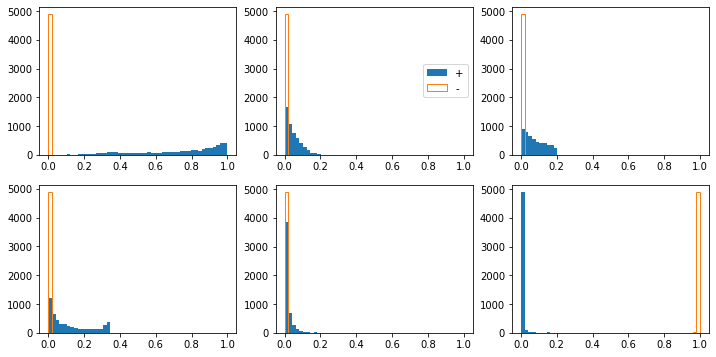

In [86]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(2,3)

for k, ax in enumerate(axs.flatten()):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='center right')

fig.set_size_inches(12,6)
plt.show()

### Testing class proportion with extra classes

#### Attempt 1

In [0]:
class ProportionCallback(Callback):
  def __init__(self, valid_x, n_classes):
    self.valid_x = valid_x
    self.n_classes = n_classes
    self.proportions = [[] for k in range(n_classes)]

  def on_train_begin(self, logs={}):
    out = self.model.predict(self.valid_x)
    for k in range(self.n_classes):
      self.proportions[k].append(out[:,k].mean())

  def on_epoch_end(self, epoch, logs={}):
    print('\rEpoch: {}'.format(epoch), end='')
    out = self.model.predict(self.valid_x)
    for k in range(self.n_classes):
      self.proportions[k].append(out[:,k].mean())

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

x_valid = get_data(10000, clusters=list('ab'))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(6, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [90]:
callback = ProportionCallback(x_valid, 6)
hist = mdl.fit(x,y, epochs=300, verbose=0, callbacks=[callback])

Epoch: 299

In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [92]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2'+' '*7+'3'+' '*7+'4'+' '*7+'5')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f} {4:1.5f} {5:1.5f} {6:1.5f}'\
        .format(sgn,out_test[k,0],out_test[k,1],out_test[k,2],out_test[k,3],out_test[k,4],out_test[k,5]))

          0       1       2       3       4       5
- --> 0.00000 0.00000 0.00000 0.00000 1.00000 0.00000
+ --> 0.00000 0.00098 0.99902 0.00000 0.00000 0.00000
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
+ --> 0.00000 0.00012 0.99988 0.00000 0.00000 0.00000
+ --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
+ --> 0.00000 0.00000 0.99999 0.00000 0.00000 0.00000
+ --> 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000
+ --> 0.00000 0.99999 0.00001 0.00000 0.00000 0.00000
+ --> 0.00000 0.00000 0.99997 0.00000 0.00003 0.00000
- --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 0.00000 0.00000 0.00000 0.00000 1.00000 0.00000
- --> 0.00000 0.00000 0.00000 0.00000 0.00221 0.99779
+ --> 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000
+ --> 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000


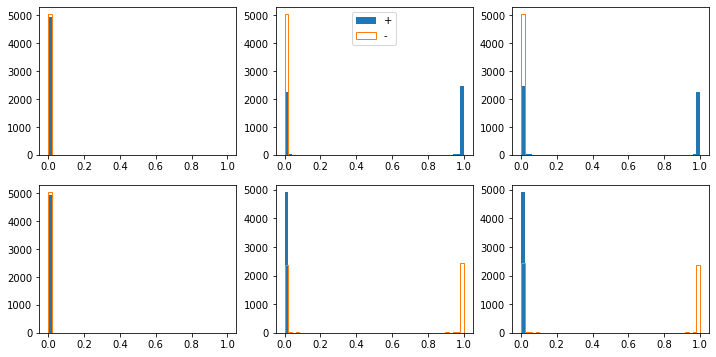

In [95]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(2,3)

for k, ax in enumerate(axs.flatten()):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='upper center')

fig.set_size_inches(12,6)
plt.show()

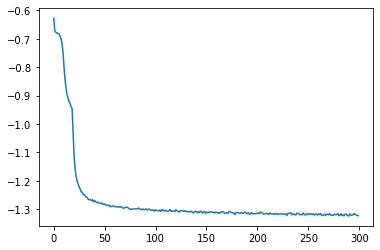

In [96]:
plt.plot(np.arange(300), hist.history['loss'])
plt.show()

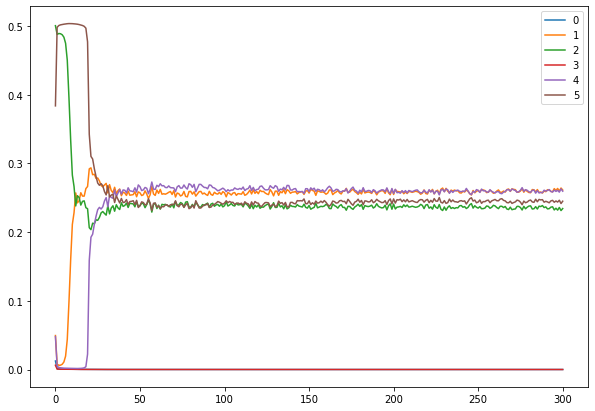

In [98]:
fig, ax = plt.subplots()
for k in range(callback.n_classes):
  ax.plot(np.arange(len(callback.proportions[k])), callback.proportions[k], label='{}'.format(k))

fig.set_size_inches(10,7)
plt.legend()
plt.show()

#### Attempt 2

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

x_valid = get_data(10000, clusters=list('ab'))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(6, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [101]:
callback = ProportionCallback(x_valid, 6)
hist = mdl.fit(x,y, epochs=300, verbose=0, callbacks=[callback])

Epoch: 299

In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [103]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2'+' '*7+'3'+' '*7+'4'+' '*7+'5')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f} {4:1.5f} {5:1.5f} {6:1.5f}'\
        .format(sgn,out_test[k,0],out_test[k,1],out_test[k,2],out_test[k,3],out_test[k,4],out_test[k,5]))

          0       1       2       3       4       5
- --> 0.00000 0.00000 0.99996 0.00004 0.00000 0.00000
+ --> 0.00006 0.00000 0.00000 0.00000 0.00000 0.99994
- --> 0.00000 0.00000 0.99993 0.00007 0.00000 0.00000
- --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
+ --> 0.00000 0.98812 0.00000 0.00004 0.01185 0.00000
+ --> 0.00000 0.00000 0.00000 0.00000 1.00000 0.00000
- --> 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000
+ --> 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000
- --> 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000
- --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
- --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
+ --> 0.00003 0.00000 0.00000 0.00000 0.00000 0.99997
- --> 0.00000 0.00000 0.99998 0.00002 0.00000 0.00000
- --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
- --> 0.00000 0.00000 0.00001 0.99999 0.00000 0.00000


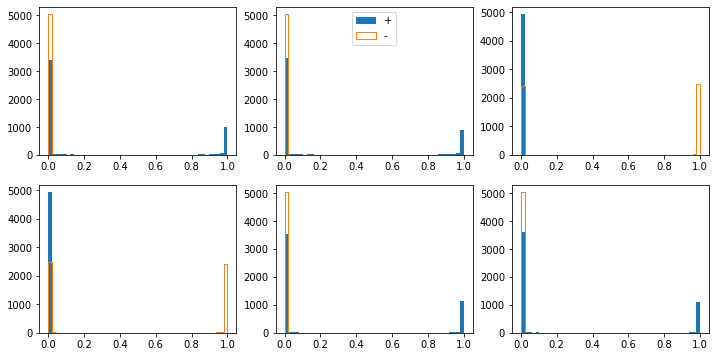

In [104]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(2,3)

for k, ax in enumerate(axs.flatten()):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='upper center')

fig.set_size_inches(12,6)
plt.show()

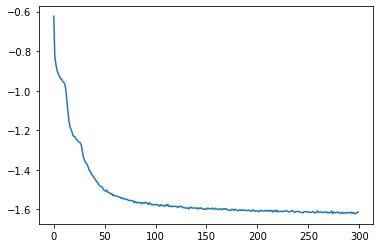

In [105]:
plt.plot(np.arange(300), hist.history['loss'])
plt.show()

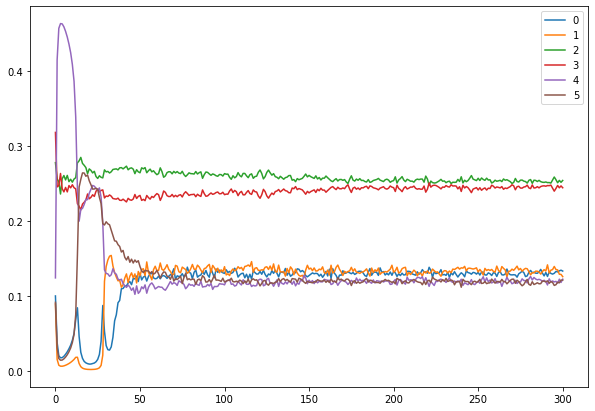

In [106]:
fig, ax = plt.subplots()
for k in range(callback.n_classes):
  ax.plot(np.arange(len(callback.proportions[k])), callback.proportions[k], label='{}'.format(k))

fig.set_size_inches(10,7)
plt.legend()
plt.show()

#### Attempt 3

In [0]:
x = get_data(10000, clusters=list('ab'))
y = np.zeros((10000,2))

x_valid = get_data(10000, clusters=list('ab'))

In [0]:
inp_layer = Input(shape=(2,))
h = Dense(5, activation='relu')(inp_layer)
out=Dense(6, activation='softmax')(h)

mdl = Model(inputs=[inp_layer], outputs=out)
mdl.compile('sgd', loss=mixed_entropy_loss)

In [109]:
callback = ProportionCallback(x_valid, 6)
hist = mdl.fit(x,y, epochs=300, verbose=0, callbacks=[callback])

Epoch: 299

In [0]:
x_test = get_data(10000, clusters=list('ab'))
out_test = mdl.predict(x_test)

In [111]:
print(' '*10+'0'+' '*7+'1'+' '*7+'2'+' '*7+'3'+' '*7+'4'+' '*7+'5')
for k in range(15):
  sgn = '+' if x_test[k,0]>0 else '-'
  print('{0} --> {1:1.5f} {2:1.5f} {3:1.5f} {4:1.5f} {5:1.5f} {6:1.5f}'\
        .format(sgn,out_test[k,0],out_test[k,1],out_test[k,2],out_test[k,3],out_test[k,4],out_test[k,5]))

          0       1       2       3       4       5
+ --> 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000
+ --> 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000
+ --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
+ --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
- --> 1.00000 0.00000 0.00000 0.00000 0.00000 0.00000
- --> 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000
+ --> 0.00000 0.00000 0.00000 0.99986 0.00000 0.00014
+ --> 0.68344 0.00000 0.00000 0.00000 0.00000 0.31656
+ --> 0.00000 0.00000 0.00000 0.00000 0.00000 1.00000
+ --> 0.00000 0.00000 0.00000 0.99957 0.00000 0.00043
+ --> 0.00000 0.00000 0.00000 0.00166 0.00000 0.99834
+ --> 0.00000 0.00000 0.00000 0.99997 0.00000 0.00003
+ --> 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000
+ --> 0.00007 0.00000 0.00000 0.00000 0.00000 0.99993
- --> 0.00000 0.90643 0.09357 0.00000 0.00000 0.00000


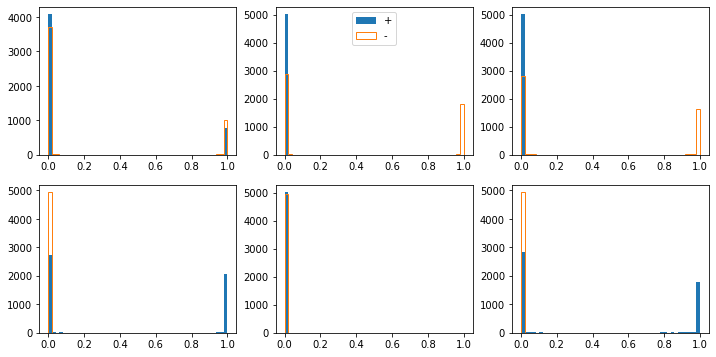

In [112]:
plusses = x_test[:,0]>0

fig, axs = plt.subplots(2,3)

for k, ax in enumerate(axs.flatten()):
  ax.hist(out_test[plusses,k], bins=np.linspace(0,1,50), label='+')
  ax.hist(out_test[~plusses,k], bins=np.linspace(0,1,50), label='-', histtype='step')
  if k == 1: ax.legend(loc='upper center')

fig.set_size_inches(12,6)
plt.show()

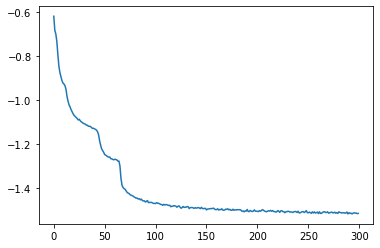

In [113]:
plt.plot(np.arange(300), hist.history['loss'])
plt.show()

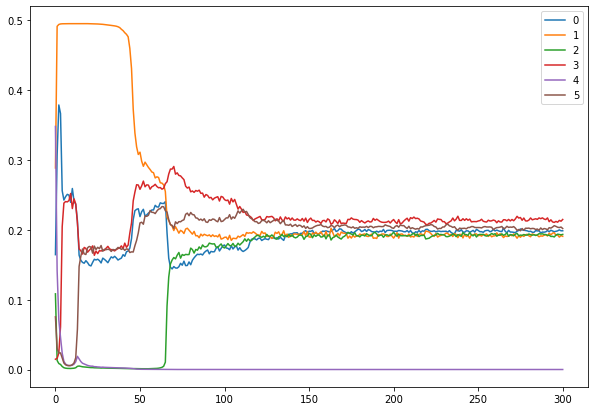

In [114]:
fig, ax = plt.subplots()
for k in range(callback.n_classes):
  ax.plot(np.arange(len(callback.proportions[k])), callback.proportions[k], label='{}'.format(k))

fig.set_size_inches(10,7)
plt.legend()
plt.show()

### Cluster counting

In [0]:
class SimpleCallback(Callback):
  def __init__(self):
    pass
  
  def on_epoch_end(self, epoch, logs={}):
    print('\rEpoch: {}'.format(epoch), end='')

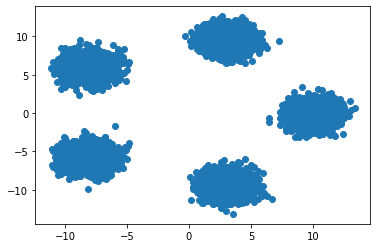

In [116]:
x = get_data(10000, clusters=list('abcde'), dist=10)

plt.scatter(x[:,0], x[:,1])
plt.show()

In [0]:
#offsetting original loss to work with homoscedastic uncertainty 
def mixed_entropy_loss(y_true, y_pred):
  eps = 1e-10

  mean = K.mean(y_pred, axis=0)
  c = K.ones_like(mean)
  c = c/K.sum(c)
  max_entropy = -K.sum(c*K.log(c+eps))

  nentropy_mean = K.mean(K.sum(y_pred*K.log(y_pred+eps), axis=1))
  mean_nentropy = K.sum(mean*K.log(mean+eps))

  return mean_nentropy - nentropy_mean + max_entropy

In [0]:
inp = Input(shape=(2,))
h = Dense(45, activation='relu')(inp)
outs = [Dense(k+2, activation='softmax')(h) for k in range(9)]
sigs = [ConstSqLayer()(out) for out in outs]
mdl = Model(inputs=[inp], outputs=outs+sigs)

In [0]:
mdl.compile('sgd', loss=[noise_loss_factory(sigs[k], mixed_entropy_loss) for k in range(9)]+[None]*9)

In [120]:
mdl.fit(x, [np.zeros((10000,k+2)) for k in range(9)], epochs=200, verbose=0, callbacks=[SimpleCallback()])

Epoch: 199

In [121]:
x_try = get_data(1, clusters=list('abcde'))
preds = mdl.predict(x_try)

for k, sig2 in enumerate([preds[k+9][0][0] for k in range(9)]):
  print('{0} {1:1.4f}'.format(k+2, np.sqrt(sig2)))

2 94.7458
3 0.3454
4 0.6253
5 5246.6406
6 0.7330
7 0.5813
8 0.7345
9 0.6858
10 1.0045


In [122]:
x_test = get_data(10000, clusters=list('abcde'), dist=10)
preds= mdl.predict(x_test)

for out in [preds[k] for k in range(9)]:
  print(['{0:1.3f}'.format(p) for p in out.mean(axis=0)])

['0.401', '0.599']
['0.205', '0.196', '0.599']
['0.100', '0.596', '0.198', '0.106']
['0.198', '0.198', '0.193', '0.206', '0.205']
['0.000', '0.195', '0.401', '0.000', '0.206', '0.198']
['0.196', '0.000', '0.078', '0.121', '0.206', '0.205', '0.195']
['0.000', '0.198', '0.000', '0.205', '0.195', '0.000', '0.196', '0.206']
['0.198', '0.000', '0.195', '0.205', '0.206', '0.070', '0.067', '0.000', '0.059']
['0.000', '0.401', '0.205', '0.000', '0.198', '0.000', '0.000', '0.000', '0.000', '0.196']


In [128]:
for k, out in enumerate([preds[k] for k in range(9)]):
  p = out.mean(axis=0)
  ent = (-p*np.log(p)).sum()
  print('{0} {1:1.4f} {2:1.4f} {3:1.4f}'.format(k+2, ent, np.log(k+2), np.log(k+2)-ent))

2 0.6734 0.6931 0.0198
3 0.9513 1.0986 0.1474
4 1.0976 1.3863 0.2887
5 1.6091 1.6094 0.0003
6 1.3313 1.7918 0.4604
7 1.7421 1.9459 0.2038
8 1.6092 2.0794 0.4703
9 1.8239 2.1972 0.3734
10 1.3314 2.3026 0.9711


#### Monitor clustering entropies over time

In [0]:
class ClusteringEntropyCallback(Callback):
  def __init__(self, valid_x, n_clusters):
    self.valid_x = valid_x
    self.n_clusters = n_clusters
    self.clustering_entropy = [[] for k in range(n_clusters-1)]

  def get_cluster_entropies(self):
    out = self.model.predict(self.valid_x)

    clustering_entropies = []
    for k in range(self.n_clusters-1):
      p = out[k].mean(axis=0)
      ent = (-p*np.log(p)).sum()
      clustering_entropies.append(np.log(k+2)-ent)

    return clustering_entropies
    
  def on_train_begin(self, logs={}):
    for k, ce in enumerate(self.get_cluster_entropies()):
      self.clustering_entropy[k].append(ce)

  def on_epoch_end(self, epoch, logs={}):
    print('\rEpoch: {}'.format(epoch), end='')
    for k, ce in enumerate(self.get_cluster_entropies()):
      self.clustering_entropy[k].append(ce)

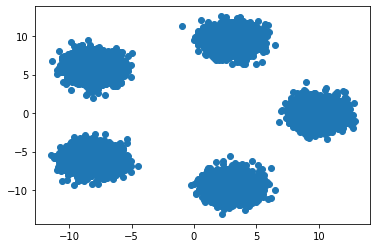

In [7]:
x = get_data(10000, clusters=list('abcde'), dist=10)

plt.scatter(x[:,0], x[:,1])
plt.show()

In [0]:
K.clear_session()

inp = Input(shape=(2,))
h = Dense(45, activation='relu')(inp)
outs = [Dense(k+2, activation='softmax')(h) for k in range(9)]
sigs = [ConstSqLayer()(out) for out in outs]
mdl = Model(inputs=[inp], outputs=outs+sigs)

In [0]:
mdl.compile('sgd', loss=[noise_loss_factory(sigs[k], mixed_entropy_loss) for k in range(9)]+[None]*9)

In [23]:
callback = ClusteringEntropyCallback(get_data(10000, clusters=list('abcde')), n_clusters=10)
mdl.fit(x, [np.zeros((10000,k+2)) for k in range(9)], epochs=200, verbose=0, callbacks=[callback])

Epoch: 199

In [24]:
x_try = get_data(1, clusters=list('abcde'))
preds = mdl.predict(x_try)

for k, sig2 in enumerate([preds[k+9][0][0] for k in range(9)]):
  print('{0} {1:1.4f}'.format(k+2, np.sqrt(sig2)))

2 0.4982
3 53.8385
4 0.3890
5 0.5610
6 0.5168
7 0.6405
8 0.5642
9 0.8094
10 0.8713


In [25]:
x_test = get_data(10000, clusters=list('abcde'), dist=10)
preds= mdl.predict(x_test)

for out in [preds[k] for k in range(9)]:
  print(['{0:1.3f}'.format(p) for p in out.mean(axis=0)])

['0.797', '0.203']
['0.394', '0.404', '0.202']
['0.202', '0.203', '0.200', '0.394']
['0.203', '0.405', '0.000', '0.200', '0.191']
['0.203', '0.203', '0.191', '0.202', '0.200', '0.000']
['0.202', '0.000', '0.200', '0.203', '0.000', '0.191', '0.203']
['0.068', '0.203', '0.063', '0.200', '0.203', '0.060', '0.000', '0.202']
['0.200', '0.203', '0.000', '0.000', '0.000', '0.202', '0.191', '0.000', '0.203']
['0.000', '0.202', '0.000', '0.000', '0.191', '0.000', '0.203', '0.203', '0.200', '0.000']


In [26]:
for k, out in enumerate([preds[k] for k in range(9)]):
  p = out.mean(axis=0)
  ent = (-p*np.log(p)).sum()
  print('{0} {1:1.4f} {2:1.4f} {3:1.4f}'.format(k+2, ent, np.log(k+2), np.log(k+2)-ent))

2 0.5051 0.6931 0.1881
3 1.0563 1.0986 0.0423
4 1.3361 1.3863 0.0502
5 1.3283 1.6094 0.2811
6 1.6092 1.7918 0.1826
7 1.6092 1.9459 0.3367
8 1.8188 2.0794 0.2606
9 1.6092 2.1972 0.5880
10 1.6092 2.3026 0.6934


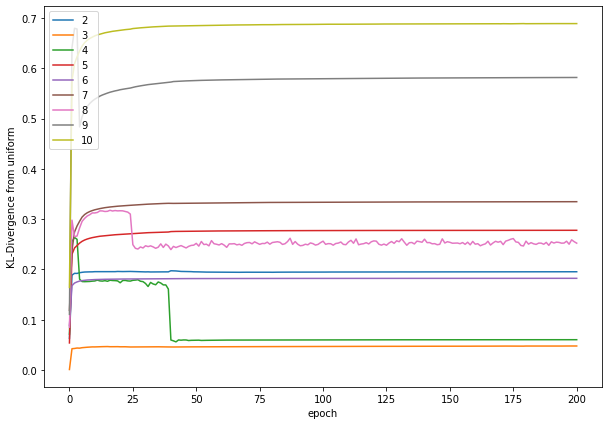

In [27]:
fig, ax = plt.subplots()

for k in range(9):
  ax.plot(np.arange(201), callback.clustering_entropy[k], label='{}'.format(k+2))

fig.set_size_inches(10,7)
ax.set_xlabel('epoch')
ax.set_ylabel('KL-Divergence from uniform')
plt.legend()
plt.show()